**<span style="color:red">Namn och CID på gruppmedlemmar: </span>**

Philip Kappel Cursaz, cursaz

Joel Sjösten Johannesson, joelsjos

Alfred Gustavsson Svedenbjörk, alfgus

In [9]:
import numpy as np
from numpy.matlib import repmat # Vi lånar funktionen repmat från matlib
from scipy import constants # Scipy constants innehåller alla möjliga fysikaliska konstanter
c = constants.speed_of_light # Vi använder det för att importera ljusets hastighet
import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [10]:
# Funktioner för HUPP:en

def xy_source(N, D_star, seperation):
    '''
        
    N:          Antalet observationspunkter (punkter längs u-axeln där fältet beräknas)
    D_star:     Stjärnans diameter [m]
    separation: Avstånd mellan punktkällorna på stjärnan [m],
                kan lämpligen anges som bråkdel av D_star, 
                t.ex. separation=D_star/30
        
    x: matris med punktkällornas x-positioner [m] 
    y: matris med punktkällornas y-positioner [m]
    M: punktkällornas antal
    
    '''

    x = np.arange(-D_star/2, D_star/2 + seperation, seperation) # Vektor med källpunkter i x-led
    y = x                                                       # och i y-led
    
    X, Y = np.meshgrid(x, y)                                    
    R    = np.sqrt(X**2 + Y**2)                                 # Längd från origo till källpunkter
    
    element_inuti_diameter = R < (D_star/2)                     # Element innanför D_star

    x = X[element_inuti_diameter]                               # Plocka ut x-koordinater som är innanför D_star
    y = Y[element_inuti_diameter]                               # och plocka ut y-koordinater

    M = np.sum(element_inuti_diameter)                          # Totalt antal källor innanför D_star
    
    return (x, y, M)

def plot_xy_source(x ,y, M):
    '''
    Skapar en figur som visar hur xy-source är placerade

    '''
    theta = np.linspace(0, 2*np.pi, 100)                      # Rita en cirkel med diameter D_star
    x_circumference = D_star/2*np.cos(theta)
    y_circumference = D_star/2*np.sin(theta)
    
    
    miljon_km = 1e6*1e3                                       # Skala om axlar till miljoner km
    
    x_miljon_km = x/miljon_km
    y_miljon_km = y/miljon_km
    
    x_circumference_miljon_km = x_circumference/miljon_km
    y_circumference_miljon_km = y_circumference/miljon_km
    
    plt.figure()
    plt.axis('equal')
    
    plt.plot(x_circumference_miljon_km, y_circumference_miljon_km, 'black')
    plt.plot(x_miljon_km, y_miljon_km, 'ro', markersize=1.4)
    
    plt.title(r'Källpositioner på stjärna. Antal källor M = ' + str(M))
    plt.xlabel('x [miljoner km]')
    plt.ylabel('y [miljoner km]')

# Uppgift a

#### Beräkna korrelationen $Γ_{AB}(𝑢)$ för positioner hos punkt $B$ från $𝑢=0$ upp till $𝑢=20$ meter.

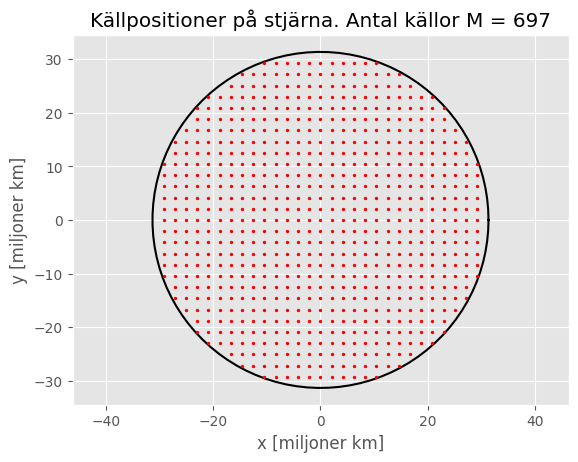

In [11]:
#%% Definiera variabler och generera källor %%#

sek_per_ar = 365.24*24*60*60                            # Sekunder på ett år
L_70  = 70*sek_per_ar*c                                 # 70 ljusår  [m]
L_300 = 300*sek_per_ar*c                                # 300 ljusår [m]

lam0  = 650e-9                                          # Våglängd [m]
k0    = 2*np.pi/lam0                                    # Vågtal   [1/m]

### Genererar källor från stjärna ###
D_sol         = 1392700e3
D_star        = 45*D_sol                                # Stjärnas diameter [m]
separation    = D_star/30                               # Separation mellan källor på stjärna

N = 500                                                 # Punkter längs u-axeln
x, y, M = xy_source(N, D_star, separation)              # Generera x och y positioner för källor
plot_xy_source(x ,y, M)                                 # Plotta stjärna med källor

### Punkter som observeras ###
u = np.linspace(0, 20, N)   
u = u.reshape(N, 1)                                     # Reshape till kolonvektor

### Skapa repeterade matriser för att undvika loopar ###
x_repeterad = repmat(x, N, 1)
y_repeterad = repmat(y, N, 1)                      
u_repeterad = repmat(u, 1, M)  

### Distans till observations punkter ###
r = -(x_repeterad * u_repeterad) / L_70                                                 # Ledning finns i HUPP-beskrivning 

#%% Summera koherenstider %##
### Initiera variabler ###
gamma   = 0                # Korrelation <E(0,0)conj(E(u,0))>
I_tot   = 0                # Tidsmedelvärdesbildad intensitet
gamma_I = 0                # Intensitetskorrelation <I(0,0)conj(I(u,0))>

### Loopa över w koherenstider ###
iterationer = 1000          # Antal iterationer/koherenstider. Använda >200 minst!
for i in range(iterationer):
    ### Generera slumpmässig fas ###
    fas           = 2*np.pi*np.random.rand(M, 1)
    fas_repeterad = np.transpose(repmat(fas, 1, N))
    
    ### Observerade värden ###
    E_k_obs       = np.exp(1j * (fas_repeterad + k0 * r))        # Given i HUPP-beskrivning
    E_obs         = np.sum(E_k_obs , 1)        # Given i HUPP-beskrivning
    inst_produkt  = E_obs[0] * np.conj(E_obs)        # Given i HUPP-beskrivning
    
    gamma         += inst_produkt        # E-fältets korrelation (amplitud o fas), summera inst_produkt i varje iteration!
    I_tot         += np.abs(E_obs)**2        # Tidsmedelvärdesbildad intensitet, summera np.abs(E_obs)**2 över alla koherenstider
    gamma_I       += (np.abs(E_obs[0])**2) * (np.abs(E_obs)**2)        # Intensitetskorrelation, samma som Gamma fast med I = np.abs(E_obs(1))**2 och np.abs(E_obs)**2

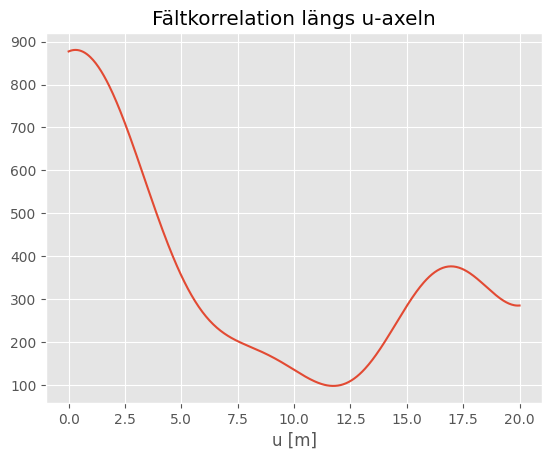

In [12]:
I_obs_inst = np.abs(E_obs)**2

plt.figure()
plt.plot(u.flatten(), np.real(I_obs_inst))
plt.xlabel('u [m]')
plt.title('Fältkorrelation längs u-axeln')
plt.grid(True)
plt.show()

Text(0, 0.5, '|\\Gamma_{I}| [arb. unit]')

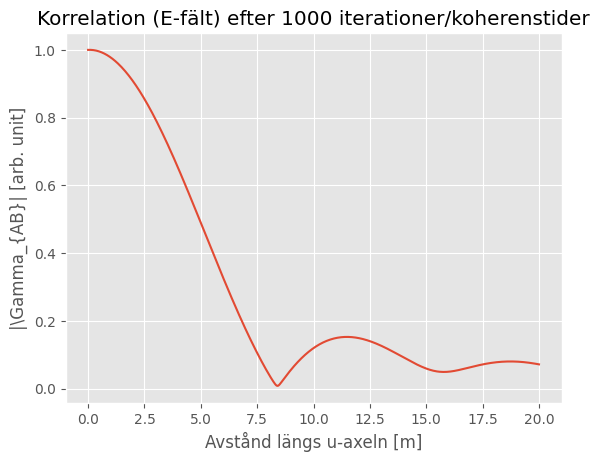

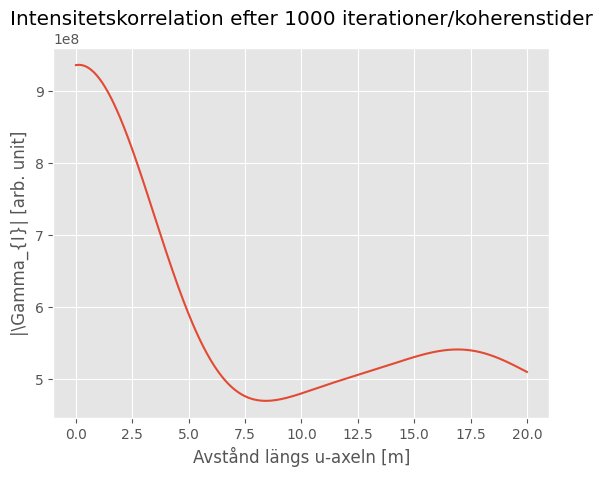

In [13]:
gamma_norm = np.abs(gamma/np.max(gamma))

plt.figure()
plt.plot(u, gamma_norm)
plt.title(r'Korrelation (E-fält) efter ' + str(iterationer) + ' iterationer/koherenstider')
plt.xlabel (r'Avstånd längs u-axeln [m]')
plt.ylabel(r'|\Gamma_{AB}| [arb. unit]')

gamma_I_norm = np.abs(gamma_I/np.max(gamma_I))

plt.figure()
plt.plot(u, gamma_I)
plt.title('Intensitetskorrelation efter ' + str(iterationer) + ' iterationer/koherenstider' )
plt.xlabel ('Avstånd längs u-axeln [m]')
plt.ylabel('|\Gamma_{I}| [arb. unit]')

# Uppgift b

####  Som en ”sanity check”, beräkna också intensiteten, i vanlig mening, i observationspunkterna (sånär som på en ointressant konstant).

(0.0, 1.1)

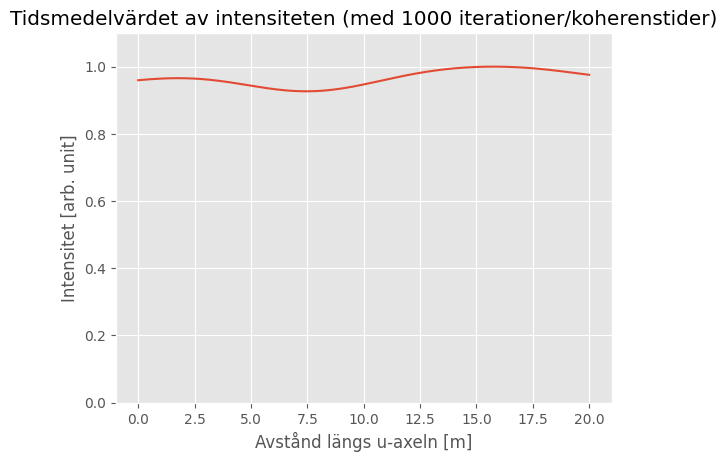

In [14]:
I_tot_norm = np.abs(I_tot/np.max(I_tot))

plt.figure()
plt.plot(u, I_tot_norm)
plt.title('Tidsmedelvärdet av intensiteten (med ' + str(iterationer) + ' iterationer/koherenstider)' )
plt.xlabel ('Avstånd längs u-axeln [m]')
plt.ylabel('Intensitet [arb. unit]')

plt.ylim([0, 1.1])

#### **Är intensitetens variation längs $u$-axeln vad du förväntar dig?**

Ja, eftersom vi har ett så stort antal oberoende punktkällor med slumpmässiga faser så borde tidsmedelvärdet av intensiteten bli nästan konstant. 

# Uppgift c

#### Kolla att du samplat punktkällorna tillräckligt tätt för att representera stjärnan på ett bra sätt. Gör detta genom att kolla att du får liknande resultat som i **(a)** även om du använder ett väsentligt annorlunda antal punktkällor.

In [15]:
#Kopierar koden från uppgift a) men ökar antalet punktkällor genom att minska separation (vi har D_star/60 istället för D_star/30).

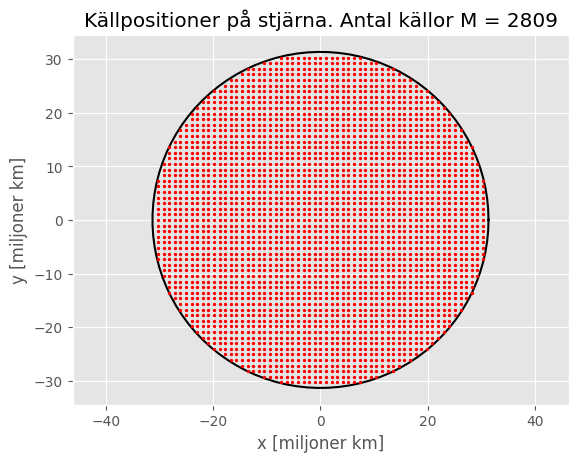

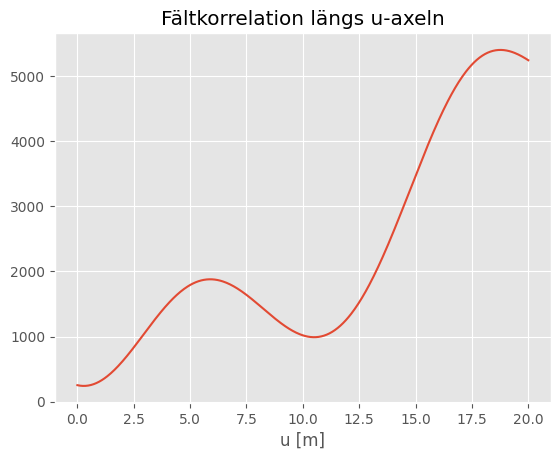

Text(0, 0.5, '|\\Gamma_{I}| [arb. unit]')

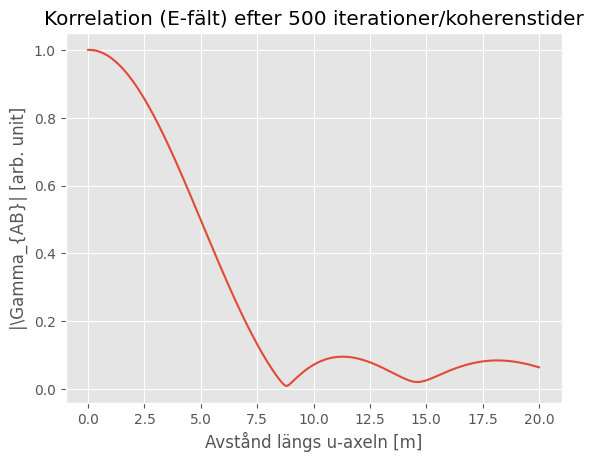

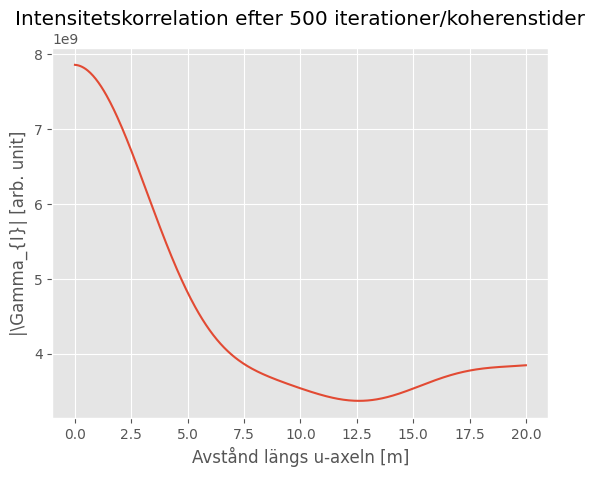

In [16]:
#%% Definiera variabler och generera källor %%#

sek_per_ar = 365.24*24*60*60                            # Sekunder på ett år
L_70  = 70*sek_per_ar*c                                 # 70 ljusår  [m]
L_300 = 300*sek_per_ar*c                                # 300 ljusår [m]

lam0  = 650e-9                                          # Våglängd [m]
k0    = 2*np.pi/lam0                                    # Vågtal   [1/m]

### Genererar källor från stjärna ###
D_sol         = 1392700e3
D_star        = 45*D_sol                                # Stjärnas diameter [m]
separation    = D_star/60                               # HÄR HAR VI ÄNDRAT

N = 500                                                 # Punkter längs u-axeln
x, y, M = xy_source(N, D_star, separation)              # Generera x och y positioner för källor
plot_xy_source(x ,y, M)                                 # Plotta stjärna med källor

### Punkter som observeras ###
u = np.linspace(0, 20, N)   
u = u.reshape(N, 1)                                     # Reshape till kolonvektor

### Skapa repeterade matriser för att undvika loopar ###
x_repeterad = repmat(x, N, 1)
y_repeterad = repmat(y, N, 1)                      
u_repeterad = repmat(u, 1, M)  

### Distans till observations punkter ###
r = -(x_repeterad * u_repeterad) / L_70                                                 # Ledning finns i HUPP-beskrivning 

#%% Summera koherenstider %##
### Initiera variabler ###
gamma   = 0                # Korrelation <E(0,0)conj(E(u,0))>
I_tot   = 0                # Tidsmedelvärdesbildad intensitet
gamma_I = 0                # Intensitetskorrelation <I(0,0)conj(I(u,0))>

### Loopa över w koherenstider ###
iterationer = 500          # Antal iterationer/koherenstider. Använda >200 minst!
for i in range(iterationer):
    ### Generera slumpmässig fas ###
    fas           = 2*np.pi*np.random.rand(M, 1)
    fas_repeterad = np.transpose(repmat(fas, 1, N))
    
    ### Observerade värden ###
    E_k_obs       = np.exp(1j * (fas_repeterad + k0 * r))        # Given i HUPP-beskrivning
    E_obs         = np.sum(E_k_obs , 1)        # Given i HUPP-beskrivning
    inst_produkt  = E_obs[0] * np.conj(E_obs)        # Given i HUPP-beskrivning
    
    gamma         += inst_produkt        # E-fältets korrelation (amplitud o fas), summera inst_produkt i varje iteration!
    I_tot         += np.abs(E_obs)**2        # Tidsmedelvärdesbildad intensitet, summera np.abs(E_obs)**2 över alla koherenstider
    gamma_I       += (np.abs(E_obs[0])**2) * (np.abs(E_obs)**2)        # Intensitetskorrelation, samma som Gamma fast med I = np.abs(E_obs(1))**2 och np.abs(E_obs)**2

I_obs_inst = np.abs(E_obs)**2

plt.figure()
plt.plot(u.flatten(), np.real(I_obs_inst))
plt.xlabel('u [m]')
plt.title('Fältkorrelation längs u-axeln')
plt.grid(True)
plt.show()

gamma_norm = np.abs(gamma/np.max(gamma))

plt.figure()
plt.plot(u, gamma_norm)
plt.title(r'Korrelation (E-fält) efter ' + str(iterationer) + ' iterationer/koherenstider')
plt.xlabel (r'Avstånd längs u-axeln [m]')
plt.ylabel(r'|\Gamma_{AB}| [arb. unit]')

gamma_I_norm = np.abs(gamma_I/np.max(gamma_I))

plt.figure()
plt.plot(u, gamma_I)
plt.title('Intensitetskorrelation efter ' + str(iterationer) + ' iterationer/koherenstider' )
plt.xlabel ('Avstånd längs u-axeln [m]')
plt.ylabel('|\Gamma_{I}| [arb. unit]')

Fältkorrelationen blir ganska annorlunda, men är fortfarande mjuk och inte taggig på något sätt. Resten av resultaten ser typ samma ut trots att vi har fler än fyra gånger så många punkter som i a). 

# Uppgift d

#### Om spatiella koherenslängden $𝑙_𝑠$ i detta specialfall (d.v.s. cirkulär inkoherent ljuskälla) mer precist definieras som avståndet mellan två punkter på $u$-axeln då korrelationen mellan deras fält blir noll (första nollstället), vad ger din simulering att $const$ har för värde i formeln: $$l_s = const \frac{\lambda}{D_{källa}} L$$

#### Testa också ett annat värde på diametern hos ljuskällan, $D_{källa}$ för att bekräfta formeln.

In [17]:
#Vi får const = l_s * D_{källa} / (lambda * L). Nu behöver vi bara bestämma l_s med den nya definitionen. Vi kopierar koden från ovan och 

def beräkna_const(D_star, L_70, lam0, k0, N=500, iterationer=500):
    separation    = D_star/100                             

    N = 100                                                 # Punkter längs u-axeln
    x, y, M = xy_source(N, D_star, separation)              # Generera x och y positioner för källor

    ### Punkter som observeras ###
    u = np.linspace(0, 20, N)   
    u = u.reshape(N, 1)                                     # Reshape till kolonvektor

    ### Skapa repeterade matriser för att undvika loopar ###
    x_repeterad = repmat(x, N, 1)
    y_repeterad = repmat(y, N, 1)                      
    u_repeterad = repmat(u, 1, M)  

    ### Distans till observations punkter ###
    r = -(x_repeterad * u_repeterad) / L_70                                                 # Ledning finns i HUPP-beskrivning 

    #%% Summera koherenstider %##
    ### Initiera variabler ###
    gamma   = 0                # Korrelation <E(0,0)conj(E(u,0))>
    I_tot   = 0                # Tidsmedelvärdesbildad intensitet
    gamma_I = 0                # Intensitetskorrelation <I(0,0)conj(I(u,0))>

    ### Loopa över w koherenstider ###
    iterationer = 500          # Antal iterationer/koherenstider. Använda >200 minst!
    for i in range(iterationer):
        ### Generera slumpmässig fas ###
        fas           = 2*np.pi*np.random.rand(M, 1)
        fas_repeterad = np.transpose(repmat(fas, 1, N))
    
        ### Observerade värden ###
        E_k_obs       = np.exp(1j * (fas_repeterad + k0 * r))        # Given i HUPP-beskrivning
        E_obs         = np.sum(E_k_obs , 1)        # Given i HUPP-beskrivning
        inst_produkt  = E_obs[0] * np.conj(E_obs)        # Given i HUPP-beskrivning
    
        gamma         += inst_produkt        # E-fältets korrelation (amplitud o fas), summera inst_produkt i varje iteration!
        I_tot         += np.abs(E_obs)**2        # Tidsmedelvärdesbildad intensitet, summera np.abs(E_obs)**2 över alla koherenstider
        gamma_I       += (np.abs(E_obs[0])**2) * (np.abs(E_obs)**2)        # Intensitetskorrelation, samma som Gamma fast med I = np.abs(E_obs(1))**2 och np.abs(E_obs)**2
    
    #Hittar l_s genom att hitta första nollstället
    gamma_real = np.real(gamma/np.max(gamma))
    idx = np.where(gamma_real <= 0)[0][0]
    l_s = u.flatten()[idx]
    
    #Beräknar const baserat på l_s och D_star
    const = l_s * D_star / (lam0 * L_70)
    return const

const1 = beräkna_const(D_star,   L_70, lam0, k0)
const2 = beräkna_const(D_star/2, L_70, lam0, k0)

print("För D_star:",   const1)
print("För D_star/2:", const2)


För D_star: 1.2941761460589067
För D_star/2: 1.1912303162587665


# Uppgift e


In [18]:
# koherenslängden l_s = ? är utläst från bilden i texten till HUPP 4 
# första nollstället när ränderna är svåra att urskilja, finns två ställen
# på bilden i HUPP-beskrivningen

l_s = 2.98 #enligt bilden

D_star_e = 1.22 * lam0 * L_300 / l_s; #Använder const = 1.22, vilket är det rätta värdet enligt föreläsningsanteckningarna.
# D_star i antal soldiametrar
print(D_star_e, "meter.")
print(D_star_e/(2*696342e3), "soldiametrar.")


755250388726.9521 meter.
542.298460186914 soldiametrar.


#### **Vad fick man för värde på stjärndiametern? Jämför med solens diameter.**



Den uppnådda stjärndiametern är 755250388726.9521 meter, vilket motsvarar 542.298460186914 soldiametrar.

# Uppgift f

#### Visa att de upprörda fysikerna hade fel! Återanvänd koden från **(b)**

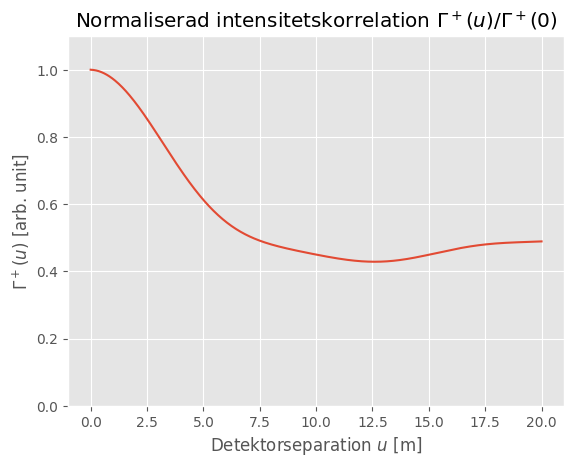

In [ ]:
plt.figure()
plt.plot(u.flatten(), gamma_I_norm)
plt.title(r'Normaliserad intensitetskorrelation $\Gamma^+(u)/\Gamma^+(0)$')
plt.xlabel('Detektorseparation $u$ [m]')
plt.ylabel(r'$\Gamma^+(u)$ [arb. unit]')
plt.grid(True)
plt.ylim([0, 1.1])
plt.show()